step sizes used: [0.05       0.025      0.0125     0.00625    0.003125   0.0015625
 0.00078125 0.00039063 0.00019531]
Part (d): Fractional difference at x = 1.5 vs finest grid (h_max = 0.05, h_min = 0.0001953125)
h            frac_diff_Euler        frac_diff_RK4
  0.050000           5.511×10⁻¹           2.219×10⁻³
  0.025000           4.153×10⁻¹           1.819×10⁻⁴
  0.012500           2.813×10⁻¹           1.249×10⁻⁵
  0.006250           1.709×10⁻¹           8.020×10⁻⁷
  0.003125           9.408×10⁻²           5.047×10⁻⁸
  0.001563           4.722×10⁻²           3.158×10⁻⁹
  0.000781           2.104×10⁻²          1.966×10⁻¹⁰
  0.000391           7.158×10⁻³          1.153×10⁻¹¹
  0.000195            0.000×10⁰            0.000×10⁰

Estimated slope/order from fractional-difference log–log fit:
  Euler  ≈ 0.88
  RK4    ≈ 3.95


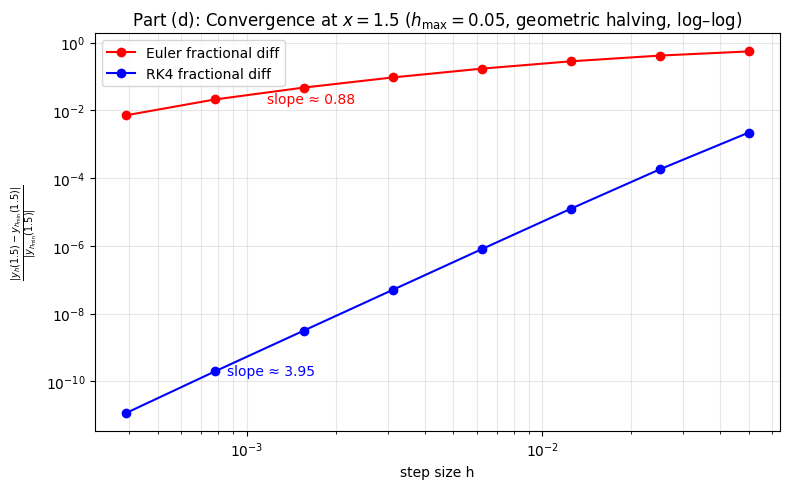

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ANSI color codes
RED   = "\033[31m"
BLUE  = "\033[34m"
GREEN = "\033[32m"
YEL   = "\033[33m"
RESET = "\033[0m"

# helper: scientific notation with Unicode superscript exponent
_sup_map = str.maketrans({
    "-": "⁻",
    "0": "⁰",
    "1": "¹",
    "2": "²",
    "3": "³",
    "4": "⁴",
    "5": "⁵",
    "6": "⁶",
    "7": "⁷",
    "8": "⁸",
    "9": "⁹",
})

def sci_sup(x, digits=3):
    """Return string like 3.347×10⁻⁴."""
    if x == 0:
        return f"{0:.{digits}f}×10⁰"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / 10**exp
    exp_str = str(exp).translate(_sup_map)
    return f"{mant:.{digits}f}×10{exp_str}"

# ODE
def f(x, y):
    return y**2 + 1
def euler(f, x0, y0, h, x_end):
    N = int((x_end - x0) / h)
    xs = np.linspace(x0, x_end, N + 1)
    ys = np.zeros(N + 1)
    ys[0] = y0
    for n in range(N):
        ys[n + 1] = ys[n] + h * f(xs[n], ys[n])
    return xs, ys

def rk4(f, x0, y0, h, x_end):
    N = int((x_end - x0) / h)
    xs = np.linspace(x0, x_end, N + 1)
    ys = np.zeros(N + 1)
    ys[0] = y0
    for n in range(N):
        x, y = xs[n], ys[n]
        k1 = f(x, y)
        k2 = f(x + 0.5 * h, y + 0.5 * h * k1)
        k3 = f(x + 0.5 * h, y + 0.5 * h * k2)
        k4 = f(x + h,       y + h * k3)
        ys[n + 1] = y + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return xs, ys
# ---------- PART (d): Convergence using fractional differences ----------
x0, y0 = 0.0, 0.0
x_end = 1.5

# use the same h values as the previous code: 0.05, 0.05/2, ..., 0.05/2^8
hs = 0.05 / (2.0 ** np.arange(0, 9))

print(f"{GREEN}step sizes used:{RESET}", hs)

# endpoint values for each h
yE_end = []
yR_end = []

for h in hs:
    _, yE = euler(f, x0, y0, h, x_end)
    _, yR = rk4(f, x0, y0, h, x_end)
    yE_end.append(yE[-1])
    yR_end.append(yR[-1])

yE_end = np.array(yE_end)
yR_end = np.array(yR_end)

# finest-grid values (smallest h) as “true”
yE_ref = yE_end[-1]
yR_ref = yR_end[-1]

# fractional differences vs finest grid
fracE = np.abs(yE_end - yE_ref) / abs(yE_ref)
fracR = np.abs(yR_end - yR_ref) / abs(yR_ref)

print(f"{YEL}Part (d): Fractional difference at x = 1.5 vs finest grid "
      f"(h_max = {hs[0]}, h_min = {hs[-1]}){RESET}")
print(f"{YEL}h            frac_diff_Euler        frac_diff_RK4{RESET}")
for h, fE, fR in zip(hs, fracE, fracR):
    print(f"{h:10.6f}   {RED}{sci_sup(fE):>18}{RESET}   {BLUE}{sci_sup(fR):>18}{RESET}")
# exclude the finest-grid point itself (fractional diff = 0)
hs_plot  = hs[:-1]
fracE_pl = fracE[:-1]
fracR_pl = fracR[:-1]

# slopes from log–log fit (order estimate)
pE, _ = np.polyfit(np.log(hs_plot), np.log(fracE_pl), 1)
pR, _ = np.polyfit(np.log(hs_plot), np.log(fracR_pl), 1)

print(f"\n{GREEN}Estimated slope/order from fractional-difference log–log fit:{RESET}")
print(f"{RED}  Euler  ≈ {pE:.2f}{RESET}")
print(f"{BLUE}  RK4    ≈ {pR:.2f}{RESET}")

# log–log plot of fractional difference vs h
plt.figure(figsize=(8,5))
plt.loglog(hs_plot, fracE_pl, 'ro-', label='Euler fractional diff')
plt.loglog(hs_plot, fracR_pl, 'bo-', label='RK4 fractional diff')
plt.xlabel("step size h")
plt.ylabel(r"$\frac{|y_h(1.5) - y_{h_{\min}}(1.5)|}{|y_{h_{\min}}(1.5)|}$")
plt.title(r"Part (d): Convergence at $x = 1.5$ ($h_{\max} = 0.05$, geometric halving, log–log)")
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# annotate slopes next to the curves (use second–finest point as anchor)
i_annot = -2  # index for annotation (second to last point)

xE = hs_plot[i_annot]
yE = fracE_pl[i_annot]
xR = hs_plot[i_annot]
yR = fracR_pl[i_annot]

# shift red (Euler) label further to the right
plt.text(xE*1.5, yE, f"slope ≈ {pE:.2f}", color='red',
         fontsize=10, va='center', ha='left')
plt.text(xR*1.1, yR, f"slope ≈ {pR:.2f}", color='blue',
         fontsize=10, va='center', ha='left')

plt.tight_layout()
plt.savefig("part_d_fractional_convergence_hmax0p05_geom_xend1.png", dpi=300)
plt.show()
